# Projet APST2 partie 1 : Q-learning/SARSA models on Frozen Lake

## Description of the problem (taken from the website)
The game starts with the player at location [0,0] of the frozen lake grid world with the goal located at far extent of the world e.g. [3,3] for the 4x4 environment.

Holes in the ice are distributed in set locations when using a pre-determined map or in random locations when a random map is generated.

The player makes moves until they reach the goal or fall in a hole.

#### Action Space
The action shape is (1,) in the range {0, 3} indicating which direction to move the player.

0: Move left

1: Move down

2: Move right

3: Move up
#### Observation Space
The observation is a value representing the player’s current position as current_row * nrows + current_col (where both the row and col start at 0).

For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15. The number of possible observations is dependent on the size of the map.

The observation is returned as an int().

#### Starting State
The episode starts with the player in state [0] (location [0, 0]).

#### Rewards
Reward schedule:

Reach goal: +1

Reach hole: 0

Reach frozen: 0

#### Episode End
The episode ends if the following happens:

Termination:

The player moves into a hole.

The player reaches the goal at max(nrow) * max(ncol) - 1 (location [max(nrow)-1, max(ncol)-1]).

In [1]:
import gymnasium as gym
import pygame



### I.First Look at the frozen Lake game
#### 1.1 Random movements

In [3]:
def random_movements(env):
    env.reset()

    while True:
        action = env.action_space.sample()  # choose a random action
        next_state, reward, done, truncated ,info = env.step(action)  
        env.render()

        if done:

         
            print(f"Game over. Reward: {reward}")
            break

env = gym.make("FrozenLake-v1", render_mode="human")

random_movements(env)




            

Game over. Reward: 0.0


We ran here a code that is performing in each step a random movement (state) that is included in the Discrete(4) space (0,1,2,3) (possible actions) , and of course the random movements will rarely lead to a final reward , as the probability of reaching the reward is very low in this case , this is why we need to use some reinforcement algorithms such as the Q-learning and SARSA in order to make these algorithms suceed in reaching the rewards.


#### 1.2 Deterministic Movements :
The argument `is_slippery` is used to determine wheither the directions choices are going to be randomized or not.If `is_slippery` is set to `True` , it means that when we choose a certain direction , we will have a probability of 1/3 of moving towards this direction , and 1/3 for both perpendicular directions.If it's set to **False** , the choosen actions will not be rejected.

Here , we are going to run a deterministic algorithm where we know the solution of the following environment : SFFF - FHFH- FFFH - HFFG , with `is_slippery` is set to `False`

In [4]:
def deterministic_movements(env,actions):
    state = env.reset()
    env.render()

    for action in actions:
        next_state, reward, done, truncated ,info = env.step(action)
        env.render()

        if done:
            print(f"Game over. Reward: {reward}")
            break

# Perform actions: down, down, right, right, down, right
actions = [1, 1, 2, 2, 1,2]
env = gym.make("FrozenLake-v1", render_mode="human", is_slippery=False)

deterministic_movements(env,actions)






Game over. Reward: 1.0


In [5]:
env.close()

### Q-learning algorithm for frozen lake

Here we are going to focus on the main problem of the reinforcement learning for the frozen lake game , where we are going to set the argument `is_slippery` to `True` , bringing a side of randomness into the chosen actions.

We decided to perform a Q-learning algorithm with an epsilon greedy method : **explain the method**

In [6]:
import numpy as np
import tqdm 
from tqdm import trange

def e_greedy(Q, state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(Q.shape[1])  # Explore (choose a random action)
    else:
        return np.argmax(Q[state, :])  # Exploit (choose the best action)

def q_learning(env,alpha,gamma,epsilon,n_loops): 
    # Initialize Q(state, action) arbitrarily
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    # Repeat (for each episode)
    for loop in range(n_loops):
        # Initialize state
        state = env.reset()[0]
        # Choose action from state using policy derived from Q (e.g., e-greedy)
        action = e_greedy(Q, state, epsilon)

        # Repeat (for each step of episode)
        while True:
            # Take action a, observe reward r, next state (s')
            state_next, r, done, truncated, _ = env.step(action)
            # Choose a' from s' using policy derived from Q (e.g., e-greedy)
            action_next = e_greedy(Q, state_next, epsilon)
            # Q(s, a) <- Q(s, a) + α[r + γ * max Q(s', a') - Q(s, a)]
            Q[state, action] = Q[state, action] + alpha * (r + gamma * np.max(Q[state_next, :]) - Q[state, action])
            # s <- s'; a <- a'
            state, action = state_next, action_next
            # until s is terminal
            if done:
                break
    return Q


#### Test of the algorithm ! 

In [10]:
def evaluate_q_learning(env, Q, num_test_episodes, render=True):
    num_wins = 0

    for episode in range(num_test_episodes):
        state = env.reset()[0]
        done = False

        while not done:
            if render:
                env.render()

            action = np.argmax(Q[state, :])
            state, reward, done,truncated ,_ = env.step(action)

            if done:
                if reward > 0:  
                    num_wins += 1

    win_rate = num_wins / num_test_episodes
    return win_rate
env=gym.make("FrozenLake-v1" ,is_slippery=True)
alpha=0.7
gamma=0.9
epsilon=0.7
num_episodes=20000
q_table=q_learning(env,alpha,gamma,epsilon,num_episodes)
num_test_episodes=10000
win_rate = evaluate_q_learning(env, q_table, num_test_episodes=num_test_episodes)
print("Results after {} tests:".format(num_test_episodes))
print(f"Win rate: {win_rate * 100}%")

c:\Users\Natsu\Anaconda3\lib\site-packages\gymnasium\envs\toy_text\frozen_lake.py:328: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("FrozenLake-v1", render_mode="rgb_array")
  gym.logger.warn(


Results after 10000 tests:
Win rate: 35.19%



To enhance the agent s performance, we will now use a modified version of the Q-learning algorithm that incorporates exponential decay. This approach will help in balancing exploration and exploitation more effectively, potentially leading to a higher win rate.

### Q-learning with Exponential Decay on the epsilon greedy parameter 

The primary purpose of incorporating exponential decay is to strike an optimal balance between exploration and exploitation during the learning process.

In the early stages of learning, it is essential for the agent to explore the environment to discover new states and actions, as this helps in acquiring valuable information. As the learning progresses, the agent should gradually shift its focus towards exploiting the knowledge it has gained, using it to make better decisions and ultimately improve its performance.

In [12]:
import numpy as np
import tqdm 
from tqdm import trange

def q_learning_decay_epsilon(env, num_episodes, alpha, gamma, initial_epsilon, decay_rate):
    # Initialize Q(s, a) arbitrarily
    Q = np.zeros((env.observation_space.n, env.action_space.n))

    # Repeat (for each episode)
    for episode in trange(num_episodes):
        # Initialize s
        state = env.reset()
        state=state[0]

        # Update epsilon
        epsilon = initial_epsilon * (decay_rate ** episode)

        # Choose a from s using policy derived from Q (e.g., e-greedy)
        action = e_greedy(Q, state, epsilon)

        # Repeat (for each step of episode)
        while True:
            # Take action a, observe r, s'
            state_next, r, done,truncated ,_ = env.step(action)

            # Choose a' from s' using policy derived from Q (e.g., e-greedy)
            action_next = e_greedy(Q, state_next, epsilon)

            # Q(s, a) <- Q(s, a) + α[r + γ * max Q(s', a') - Q(s, a)]
            Q[state, action] = Q[state, action] + alpha * (r + gamma * np.max(Q[state_next, :]) - Q[state, action])

            # state <- state'; a <- a'
            state, action = state_next, action_next

            # until s is terminal
            if done:
                break

    return Q


#### Test of the algorithm ! 

In [13]:
env = gym.make('FrozenLake-v1', is_slippery=True)
alpha = 0.7
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01 
epsilon_decay = 0.999
num_episodes = 20000
q_table_epsilon_decay=q_learning_decay_epsilon(env=env, num_episodes=num_episodes, alpha=alpha, gamma=gamma, initial_epsilon=epsilon, decay_rate=epsilon_decay)
win_rate = evaluate_q_learning(env, q_table_epsilon_decay, num_test_episodes=num_test_episodes)
print("Results after {} tests:".format(num_test_episodes))
print(f"Win rate: {win_rate * 100}%")

100%|██████████| 20000/20000 [00:22<00:00, 900.06it/s] 
c:\Users\Natsu\Anaconda3\lib\site-packages\gymnasium\envs\toy_text\frozen_lake.py:328: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("FrozenLake-v1", render_mode="rgb_array")
  gym.logger.warn(


Results after 10000 tests:
Win rate: 82.82000000000001%


We can observe a much higher and better score than what we got without the exponential decay, we can even try to optimize the method by fine tuning the parameters and get the optimal values of the hyperparameters.

#### Fine tuning des hyperparametres : 

In [14]:

from itertools import product
# Define the hyperparameters to search over
alphas = [0.3,0.99, 0.7, 0.9]
gammas = [0.97,0.98, 0.99]
decay_rates = [0.999]
initial_epsilon=1
# Run a grid search over the hyperparameters
best_win_rate = 0
best_hyperparams = None
for alpha, gamma, decay_rate in product(alphas, gammas, decay_rates):
    q_table = q_learning_decay_epsilon(env, num_episodes=num_episodes, alpha=alpha, gamma=gamma, initial_epsilon=initial_epsilon, decay_rate=decay_rate)
    win_rate = evaluate_q_learning(env, q_table, num_test_episodes=num_test_episodes, render=False)
    print("alpha={}, gamma={}, initial_epsilon={}, decay_rate={}, win_rate={}".format(alpha, gamma, initial_epsilon, decay_rate, win_rate))
    if win_rate > best_win_rate:
        best_win_rate = win_rate
        best_hyperparams = (alpha, gamma, initial_epsilon, decay_rate)

print("Best hyperparameters: alpha={}, gamma={}, initial_epsilon={}, decay_rate={}".format(*best_hyperparams))
q_table_decay_epsilon = q_learning_decay_epsilon(env, num_episodes=num_episodes, alpha=best_hyperparams[0], gamma=best_hyperparams[1], initial_epsilon=best_hyperparams[2], decay_rate=best_hyperparams[3])
win_rate = evaluate_q_learning(env, q_table_decay_epsilon, num_test_episodes=num_test_episodes, render=True)
print("Results after {} tests:".format(num_test_episodes))
print(f"Win rate: {win_rate * 100}%")

100%|██████████| 20000/20000 [00:21<00:00, 920.33it/s] 


alpha=0.3, gamma=0.97, initial_epsilon=1, decay_rate=0.999, win_rate=0.8215


100%|██████████| 20000/20000 [00:24<00:00, 811.71it/s]


alpha=0.3, gamma=0.98, initial_epsilon=1, decay_rate=0.999, win_rate=0.8186


100%|██████████| 20000/20000 [00:19<00:00, 1021.11it/s]


alpha=0.3, gamma=0.99, initial_epsilon=1, decay_rate=0.999, win_rate=0.6961


100%|██████████| 20000/20000 [00:29<00:00, 669.97it/s]


alpha=0.99, gamma=0.97, initial_epsilon=1, decay_rate=0.999, win_rate=0.8285


100%|██████████| 20000/20000 [00:29<00:00, 670.73it/s] 


alpha=0.99, gamma=0.98, initial_epsilon=1, decay_rate=0.999, win_rate=0.754


100%|██████████| 20000/20000 [00:33<00:00, 591.12it/s]


alpha=0.99, gamma=0.99, initial_epsilon=1, decay_rate=0.999, win_rate=0.8226


100%|██████████| 20000/20000 [00:18<00:00, 1072.15it/s]


alpha=0.7, gamma=0.97, initial_epsilon=1, decay_rate=0.999, win_rate=0.8281


100%|██████████| 20000/20000 [00:22<00:00, 902.65it/s] 


alpha=0.7, gamma=0.98, initial_epsilon=1, decay_rate=0.999, win_rate=0.8265


100%|██████████| 20000/20000 [00:24<00:00, 802.41it/s] 


alpha=0.7, gamma=0.99, initial_epsilon=1, decay_rate=0.999, win_rate=0.8245


100%|██████████| 20000/20000 [00:19<00:00, 1019.15it/s]


alpha=0.9, gamma=0.97, initial_epsilon=1, decay_rate=0.999, win_rate=0.8254


100%|██████████| 20000/20000 [00:29<00:00, 670.76it/s]


alpha=0.9, gamma=0.98, initial_epsilon=1, decay_rate=0.999, win_rate=0.8209


100%|██████████| 20000/20000 [00:23<00:00, 840.78it/s] 


alpha=0.9, gamma=0.99, initial_epsilon=1, decay_rate=0.999, win_rate=0.8212
Best hyperparameters: alpha=0.99, gamma=0.97, initial_epsilon=1, decay_rate=0.999


100%|██████████| 20000/20000 [00:21<00:00, 937.55it/s] 


Results after 10000 tests:
Win rate: 81.99%


In [42]:
print('The best values for (alpha,gamma,initial_epsilon,decay_rate) are',best_hyperparams , 'which got a win rate of ' , best_win_rate)

alpha,gamma,initial_epsilon,decay_rate=best_hyperparams

The best values for (alpha,gamma,initial_epsilon,decay_rate) are (0.99, 0.97, 1, 0.999) which got a win rate of  0.8285


### Q-learning with exponential decay on epsilon and the learning rate parameters 

Here, we are using the exponential decay method on both the epsilon and the learning rate parameters to see if there are any improvements


In [28]:
def q_learning_decay_epsilon_alpha(env, num_episodes, initial_alpha, gamma, initial_epsilon, alpha_decay_rate,epsilon_decay_rate):
    # Initialize Q(s, a) arbitrarily
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_per_episode = []

    # Repeat (for each episode)
    for episode in trange(num_episodes):
        # Initialize s
        state = env.reset()
        state=state[0]

        # Update epsilon
        alpha = initial_alpha * (alpha_decay_rate ** episode)
        epsilon = initial_epsilon * (epsilon_decay_rate ** episode)

        # Choose a from s using policy derived from Q (e.g., e-greedy)
        action = e_greedy(Q, state, epsilon)
        total_reward = 0

        # Repeat (for each step of episode)
        while True:
            # Take action a, observe r, s'
            state_next, r, done,truncated ,_ = env.step(action)
            total_reward += r

            # Choose a' from s' using policy derived from Q (e.g., e-greedy)
            action_next = e_greedy(Q, state_next, epsilon)

            # Q(s, a) <- Q(s, a) + α[r + γ * max Q(s', a') - Q(s, a)]
            Q[state, action] = Q[state, action] + alpha * (r + gamma * np.max(Q[state_next, :]) - Q[state, action])

            # state <- state'; a <- a'
            state, action = state_next, action_next

            # until s is terminal
            if done:
                break
        rewards_per_episode.append(total_reward)

    return Q,rewards_per_episode


#### Test of the algo : 

In [29]:
# Initialize the environment
env=gym.make('FrozenLake-v1', is_slippery=True)

# Q-learning parameters
alpha = 1.0
alpha_decay = 0.999
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.999
num_episodes = 20000
num_test_episodes=1000
q_table_decay_epsilon_alpha,rewards_per_episode=q_learning_decay_epsilon_alpha(env=env,num_episodes=num_episodes,initial_epsilon=epsilon,epsilon_decay_rate=epsilon_decay,alpha_decay_rate=alpha_decay,gamma=gamma,initial_alpha=alpha)

win_rate = evaluate_q_learning(env, q_table_decay_epsilon_alpha, num_test_episodes=1000)
print("Results after {} tests:".format(num_test_episodes))
print(f"Win rate: {win_rate * 100}%")

100%|██████████| 20000/20000 [00:23<00:00, 846.66it/s]
c:\Users\Natsu\Anaconda3\lib\site-packages\gymnasium\envs\toy_text\frozen_lake.py:328: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("FrozenLake-v1", render_mode="rgb_array")
  gym.logger.warn(


Results after 1000 tests:
Win rate: 82.39999999999999%


### Policy visualization : 

C:\Users\Natsu\AppData\Local\Temp\ipykernel_16516\4254730763.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Pastel1", 4)


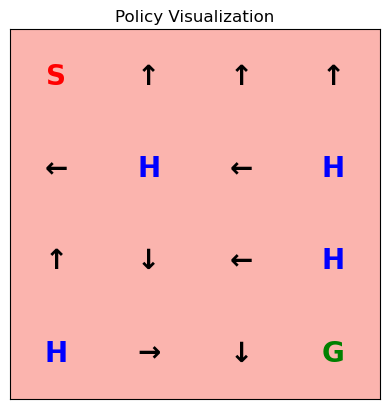

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_policy(q_table, frozen_lake_map):
    action_dict = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    policy = np.argmax(q_table, axis=1).reshape((4, 4))

    fig, ax = plt.subplots()
    cmap = plt.cm.get_cmap("Pastel1", 4)
    ax.matshow(np.ones((4, 4)), cmap=cmap)

    for row in range(4):
        for col in range(4):
            if frozen_lake_map[row][col] == 'F':
                ax.text(col, row, action_dict[policy[row, col]], ha='center', va='center', fontsize=20, fontweight='bold', color='k')
            elif frozen_lake_map[row][col] == 'S':
                ax.text(col, row, 'S', ha='center', va='center', fontsize=20, fontweight='bold', color='r')
            elif frozen_lake_map[row][col] == 'G':
                ax.text(col, row, 'G', ha='center', va='center', fontsize=20, fontweight='bold', color='g')
            else:
                ax.text(col, row, 'H', ha='center', va='center', fontsize=20, fontweight='bold', color='b')

    plt.xticks([])
    plt.yticks([])
    plt.title("Policy Visualization")
    plt.show()


frozen_lake_map = [
    ['S', 'F', 'F', 'F'],
    ['F', 'H', 'F', 'H'],
    ['F', 'F', 'F', 'H'],
    ['H', 'F', 'F', 'G']
]
visualize_policy(q_table_decay_epsilon_alpha,frozen_lake_map=frozen_lake_map)

This policy visualization shows the action that the algorithm will take in each state , if you try to play at this game you will likely end up choosing the same actions in the same state !! 

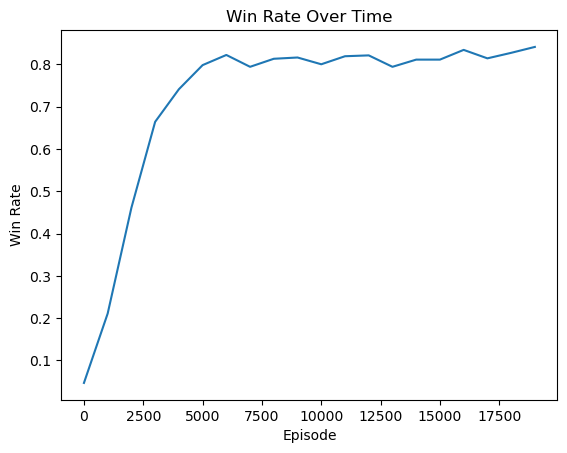

In [32]:
def win_rate_over_time(rewards_per_episode, episode_interval):
    win_rate = [np.mean(rewards_per_episode[i:i + episode_interval]) for i in range(0, len(rewards_per_episode), episode_interval)]
    x_ticks = range(0, len(rewards_per_episode), episode_interval)
    
    plt.plot(x_ticks, win_rate)
    plt.xlabel("Episode")
    plt.ylabel("Win Rate")
    plt.title("Win Rate Over Time")
    plt.show()


win_rate_over_time(rewards_per_episode=rewards_per_episode,episode_interval=1000)



## SARSA algorithm 

In [35]:
def epsilon_greedy(q, state, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(q.shape[1])
    else:
        return np.argmax(q[state, :])



def sarsa_decay_epsilon(alpha, epsilon, gamma, episodes, env, epsilon_decay):
    q=np.zeros((env.observation_space.n, env.action_space.n))

    for episode in trange(episodes):
        state = env.reset()[0]
        action = e_greedy(q, state, epsilon)
        total_reward = 0

        while True:
            next_state, reward, done,truncated, _ = env.step(action)
            next_action = epsilon_greedy(q, next_state, epsilon)
            q[state, action] = (1 - alpha) * q[state, action] + alpha * (reward + gamma * q[next_state, next_action])

            state = next_state
            action = next_action
            total_reward += reward

            if done:
                break

        epsilon *= epsilon_decay
    return q,epsilon

env = gym.make("FrozenLake-v1",is_slippery=True)
initial_alpha=0.8
initial_epsilon=1
alpha_decay_rate=0.9
epsilon_decay_rate=0.999
gamma=0.99
num_episodes=20000
q_table_sarsa,final_epsilon = sarsa_decay_epsilon(env=env, episodes=num_episodes, alpha=initial_alpha, epsilon=initial_epsilon, epsilon_decay=epsilon_decay_rate, gamma=gamma)

num_test_episodes=1000
win_rate = evaluate_q_learning(env, q_table_sarsa, num_test_episodes=num_test_episodes)
print("Results after {} tests:".format(num_test_episodes))
print(f"Win rate: {win_rate * 100}%" , final_epsilon)

100%|██████████| 20000/20000 [00:22<00:00, 890.03it/s]


Results after 1000 tests:
Win rate: 83.2% 2.040631186762095e-09


In [45]:
def sarsa_decay_alpha_epsilon(env, num_episodes, initial_alpha, initial_epsilon, alpha_decay_rate, epsilon_decay_rate, gamma):
    # Initialize Q(s, a) arbitrarily
    Q = np.zeros((env.observation_space.n, env.action_space.n))

    # Repeat (for each episode)
    for episode in trange(num_episodes):
        # Initialize s
        state = env.reset()[0]

        # Update alpha and epsilon
        alpha = initial_alpha * (alpha_decay_rate ** episode)
        epsilon =initial_epsilon * (epsilon_decay_rate ** episode)

        # Choose a from s using policy derived from Q (e.g., e-greedy)
        action = e_greedy(Q, state, epsilon)

        # Repeat (for each step of episode)
        while True:
            # Take action a, observe r, s'
            state_next, r, done,truncated ,_ = env.step(action)

            # Choose a' from s' using policy derived from Q (e.g., e-greedy)
            action_next = e_greedy(Q, state_next, epsilon)

            # Q(s, a) <- Q(s, a) + α[r + γ * Q(s', a') - Q(s, a)]
            Q[state, action] = Q[state, action] + alpha * (r + gamma * Q[state_next, action_next] - Q[state, action])

            # s <- s'; a <- a'
            state, action= state_next, action_next

            # until s is terminal
            if done:
                break

    return Q


env = gym.make("FrozenLake-v1",is_slippery=True)
initial_alpha=1
initial_epsilon=1
alpha_decay_rate=0.999
epsilon_decay_rate=0.999
gamma=0.97
num_episodes=20000
q_table_sarsa = sarsa_decay_alpha_epsilon(env, num_episodes=num_episodes, initial_alpha=initial_alpha, initial_epsilon=initial_epsilon, alpha_decay_rate=alpha_decay_rate, epsilon_decay_rate=epsilon_decay_rate, gamma=gamma)

num_test_episodes=1000
win_rate = evaluate_q_learning(env, q_table_sarsa, num_test_episodes=num_test_episodes)
print("Results after {} tests:".format(num_test_episodes))
print(f"Win rate: {win_rate * 100}%")


100%|██████████| 20000/20000 [00:17<00:00, 1129.96it/s]


Results after 1000 tests:
Win rate: 80.7%


C:\Users\Natsu\AppData\Local\Temp\ipykernel_16516\4254730763.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Pastel1", 4)


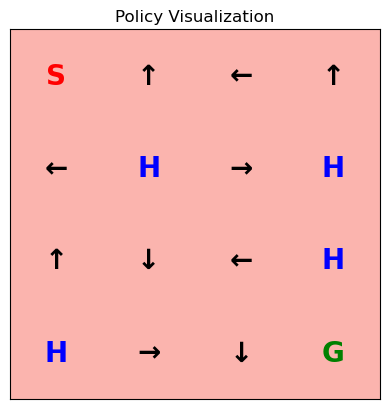

In [47]:
visualize_policy(q_table_sarsa,frozen_lake_map=frozen_lake_map)